In [26]:
import numpy as np
import pandas as pd
import datetime as dt
import netCDF4 as nc
from matplotlib import pyplot as plt
from salishsea_tools import geo_tools, evaltools as et

%matplotlib inline

In [2]:
df1=pd.read_csv('/ocean/eolson/MEOPAR/obs/ONC/node/search12730020/East_StraitofGeorgiaEastVENUSInstrumentPlatform_ConductivityTemperatureDepth_Temperature_20080901T000000Z_20200215T000000Z-NaN_clean_avg1day.csv',
        skiprows=166,header=None,
        names=('TimeUTC', 'Temperature', 'TemperatureQC' , 'TemperatureCount'),na_values=' NaN')

In [3]:
df1.head()

,TimeUTC,Temperature,TemperatureQC,TemperatureCount
0,2008-09-01T12:00:00.000Z,9.742203,7,1395
1,2008-09-02T12:00:00.000Z,9.479952,7,1440
2,2008-09-03T12:00:00.000Z,9.099971,7,1440
3,2008-09-04T12:00:00.000Z,9.043725,7,1440
4,2008-09-05T12:00:00.000Z,9.051358,7,1440


In [4]:
#yyyy-mm-ddThh:mm:ss.fffZ
df1['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%dT12:00:00.000Z') for ii in df1['TimeUTC']]

In [5]:
df1.head()

,TimeUTC,Temperature,TemperatureQC,TemperatureCount,dtUTC
0,2008-09-01T12:00:00.000Z,9.742203,7,1395,2008-09-01
1,2008-09-02T12:00:00.000Z,9.479952,7,1440,2008-09-02
2,2008-09-03T12:00:00.000Z,9.099971,7,1440,2008-09-03
3,2008-09-04T12:00:00.000Z,9.043725,7,1440,2008-09-04
4,2008-09-05T12:00:00.000Z,9.051358,7,1440,2008-09-05


/home/eolson/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


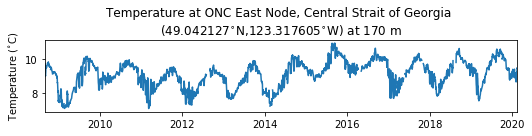

In [6]:
fig,ax=plt.subplots(1,1,figsize=(7.5,2))
ax.plot(df1['dtUTC'],df1['Temperature'])#
ax.set_ylabel('Temperature ($^{\circ}$C)')
ax.set_title('Temperature at ONC East Node, Central Strait of Georgia \n(49.042127$^{\circ}$N,123.317605$^{\circ}$W) at 170 m')
ax.set_xlim(df1['dtUTC'].values[0],df1['dtUTC'].values[-1])
plt.tight_layout()
fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/response/T.png',dpi=200)

In [7]:
np.min(df1['Temperature']),np.max(df1['Temperature'])

(7.098262847000001, 10.945951667000001)

In [24]:
df2=df1.loc[(df1['dtUTC']>dt.datetime(2015,1,1))&(df1['dtUTC']<dt.datetime(2018,1,1))].copy(deep=True).reset_index()

In [25]:
df2

,index,TimeUTC,Temperature,TemperatureQC,TemperatureCount,dtUTC
0,2309,2015-01-02T12:00:00.000Z,9.521381,7,1440,2015-01-02
1,2310,2015-01-03T12:00:00.000Z,9.503221,7,1440,2015-01-03
2,2311,2015-01-04T12:00:00.000Z,9.486890,7,1440,2015-01-04
3,2312,2015-01-05T12:00:00.000Z,9.518449,7,1440,2015-01-05
4,2313,2015-01-06T12:00:00.000Z,9.478761,7,1440,2015-01-06
...,...,...,...,...,...,...
1098,3407,2017-12-27T12:00:00.000Z,9.207022,7,86399,2017-12-27
1099,3408,2017-12-28T12:00:00.000Z,9.305037,7,86399,2017-12-28
1100,3409,2017-12-29T12:00:00.000Z,8.793474,7,86399,2017-12-29
1101,3410,2017-12-30T12:00:00.000Z,8.601840,7,86399,2017-12-30


In [34]:
lat=49.042127
lon=-123.317605
z=169.5
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    navlon=mesh.variables['nav_lon'][:,:]
    navlat=mesh.variables['nav_lat'][:,:]
    e3t_0=mesh.variables['e3t_0'][0,:,:,:]
    tmask=mesh.variables['tmask'][0,:,:,:]
j,i=geo_tools.find_closest_model_point(lon,lat,navlon,navlat)

In [36]:
bathy=np.sum(e3t_0*tmask,0)
bathy[j,i], np.sum(tmask[:,j,i])

(163.41523360331595, 30)

In [38]:
tmask[30-1,j,i]

1

In [49]:
df2['j']=j
df2['i']=i
df2['Z']=160 # bottom of model domain
df2['mod_nitrate']=np.nan
df2['mod_votemper']=np.nan

In [42]:
mod_start=dt.datetime(2015,1,1)
mod_end=dt.datetime(2018,1,1)
mod_basedir='/results2/SalishSea/nowcast-green.201812/'
mod_nam_fmt='nowcast'
mod_flen=1
ftypes=('ptrc_T','grid_T')
filemap_r={'ptrc_T':('nitrate',),'grid_T':('votemper',)}
flist=dict()
for ift in ftypes:
    flist[ift]=et.index_model_files(mod_start,mod_end,mod_basedir,mod_nam_fmt,mod_flen,ift,1)

In [45]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fmesh:
    omask=np.copy(fmesh.variables['tmask'])

In [50]:
data=et._binmatch(df2,flist,ftypes,filemap_r,omask,maskName='tmask',sdim=3)

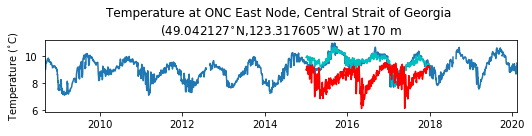

In [58]:
fig,ax=plt.subplots(1,1,figsize=(7.5,2))
ax.plot(df1['dtUTC'],df1['Temperature'])#
ax.set_ylabel('Temperature ($^{\circ}$C)')
ax.set_title('Temperature at ONC East Node, Central Strait of Georgia \n(49.042127$^{\circ}$N,123.317605$^{\circ}$W) at 170 m')
ax.set_xlim(df1['dtUTC'].values[0],df1['dtUTC'].values[-1])
ax.plot(data['dtUTC'],data['mod_votemper'],'c-')
ax.plot(data['dtUTC'],data['mod_nitrate']/3,'r-')
plt.tight_layout()
#fig.savefig('/data/eolson/MEOPAR/biomodelevalpaper/response/T.png',dpi=200)